# Machine Learning Model with Combined Time-Series and Tabular Data

## Introduction

This notebook presents the development of a machine learning model that integrates two types of patient data: time-series data and static tabular data. Time-series data, such as Mean Heart Rate (Mean_HR), Heart Rate Variability (SDNN_HRV), and the HF/LF ratio, provides a sequence of values over time, capturing trends and temporal dependencies that can be indicative of patient health status. On the other hand, tabular data, which includes demographic and static health information such as age, gender, and other vital signs, provides crucial context and background for each patient.

By combining these data types, we aim to create a robust model that leverages the temporal patterns in time-series data while simultaneously drawing insights from the static features in tabular data. This multi-input approach allows the model to better capture the nuances of patient health and potentially improve prediction accuracy for clinical outcomes.

The steps outlined in this notebook include data loading and preprocessing, model architecture design, and model training and evaluation. The use of a unique patient identification (patient ID) enables the seamless linking of tabular and time-series data, ensuring that each patient's information is properly aligned across datasets. The resulting model is designed to predict patient outcomes by integrating the complementary insights provided by both data types.


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and time-series preprocessing
from sklearn.model_selection import train_test_split

# TensorFlow / Keras (for deep learning model)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Masking, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC

# Metrics and evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

import pickle

## 1. Load all needed data

In [2]:
# Loading the dataset that has been fully prepared for distance based prediction
with open('data/machine_learning_patient_data.pkl', 'rb') as f:
    machine_learning_patient_data = pickle.load(f)

machine_learning_patient_data

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc
0,284,-0.522787,False,True,True,False,True,False,False,False,True,False,-0.215362
1,286,1.525272,True,False,False,False,False,False,True,True,False,False,-1.023892
2,296,-0.842797,False,True,True,False,False,True,False,False,True,False,-0.215362
3,299,-1.034802,False,True,True,False,True,False,False,False,True,False,-0.215362
4,303,-0.650791,False,True,True,False,True,False,False,False,True,False,0.225655
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,1.653275,False,True,True,False,True,False,False,True,False,False,-1.023892
603,1017,-2.250837,False,True,True,False,False,False,True,True,False,False,2.283731
604,1018,0.117231,False,True,True,False,False,True,False,False,True,False,0.041898
605,1019,0.693248,False,True,True,False,False,True,False,False,True,False,-0.215362


In [3]:
# Load ecg data
ecg_data = pd.read_csv('data/ecg_data.csv')

ecg_data

,Patient_ID,Segment_1_Mean_HR,Segment_1_HRV_SDNN,Segment_1_LF_Power,Segment_1_HF_Power,Segment_1_LF_HF_Ratio,Segment_2_Mean_HR,Segment_2_HRV_SDNN,Segment_2_LF_Power,Segment_2_HF_Power,...,Segment_287_Mean_HR,Segment_287_HRV_SDNN,Segment_287_LF_Power,Segment_287_HF_Power,Segment_287_LF_HF_Ratio,Segment_288_Mean_HR,Segment_288_HRV_SDNN,Segment_288_LF_Power,Segment_288_HF_Power,Segment_288_LF_HF_Ratio
0,284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.421582,0.981133,-0.093946,-0.088465,-0.096152,0.344520,1.128406,-0.063206,-0.062188,-0.238693
1,286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.565307,1.816490,-0.073634,-0.100386,-0.059189,0.482280,0.000000,-0.061845,-0.061378,-0.176915
2,296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.185734,2.456931,-0.111831,-0.085917,-0.109046,-0.516477,0.501520,-0.063652,-0.062835,-0.192359
4,303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.210580,-0.759196,-0.182218,-0.129349,-0.121940,-1.170835,0.002860,-0.063798,-0.062743,-0.303560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.565307,1.732954,-0.051216,-0.064506,-0.099590,-0.516477,1.641312,-0.062859,-0.062057,-0.201626
603,1017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
604,1018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.484386,-1.065494,0.000000,-0.130722,0.000000,1.308837,-0.880479,-0.063911,-0.063067,-0.189271
605,1019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.058751,-0.870577,-0.182119,-0.130566,0.092101,-1.033075,-0.125366,-0.063918,-0.063072,-0.195448


In [4]:
# Loading the dataset that has the target value and original features and values
with open('data/patient_data.pkl', 'rb') as f:
    patient_data = pickle.load(f)

# Map 'Good' to 1 and 'Poor' to 0
patient_data['outcome'] = patient_data['outcome'].map({'Good': 1, 'Poor': 0}).astype(int)


patient_data

,Patient,hospital,age,sex,rosc,ohca,shockable_rhythm,ttm,outcome,cpc,rosc_missing,shockable_rhythm_missing
0,284,A,53.0,Male,NaN,True,True,33.0,1,1,1,0
1,286,F,85.0,Female,7.0,False,False,No TTM,1,1,0,0
2,296,A,48.0,Male,NaN,True,True,36.0,1,1,1,0
3,299,A,45.0,Male,NaN,True,True,33.0,1,1,1,0
4,303,D,51.0,Male,24.0,True,True,33.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,E,87.0,Male,7.0,True,False,33.0,0,5,0,0
603,1017,F,26.0,Male,52.0,True,False,No TTM,0,5,0,0
604,1018,E,63.0,Male,NaN,True,True,36.0,0,5,1,0
605,1019,A,72.0,Male,NaN,True,True,36.0,1,1,1,0


## 2. Combine the DataFrames

To prepare the data for analysis, we will combine the patient demographic data from `machine_learning_patient_data` with the ECG evaluations in `ecg_data`. Each patient’s information should be stored in a single row to ensure all relevant data is aligned correctly. 

We’ll perform the combination by merging the two DataFrames on the `Patient` column from `machine_learning_patient_data` and the `Patient_ID` column from `ecg_data`, which uniquely identify each patient across the datasets. 

This step enables us to work with a unified dataset, making it easier to analyze patient data holistically and develop machine learning models using both tabular and time-series data.

In [5]:
# Step 1: Merge machine_learning_patient_data and ecg_data on patient identifiers
combined_data = pd.merge(
    machine_learning_patient_data, ecg_data, 
    left_on='Patient', right_on='Patient_ID', 
    how='inner'
)

# Step 2: Merge the resulting combined_data with patient_data to add the 'outcome' column
combined_data = pd.merge(
    combined_data, patient_data[['Patient', 'outcome']], 
    on='Patient', 
    how='inner'
)

# Display the first few rows of the combined DataFrame to verify
combined_data

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,...,Segment_287_HRV_SDNN,Segment_287_LF_Power,Segment_287_HF_Power,Segment_287_LF_HF_Ratio,Segment_288_Mean_HR,Segment_288_HRV_SDNN,Segment_288_LF_Power,Segment_288_HF_Power,Segment_288_LF_HF_Ratio,outcome
0,284,-0.522787,False,True,True,False,True,False,False,False,...,0.981133,-0.093946,-0.088465,-0.096152,0.344520,1.128406,-0.063206,-0.062188,-0.238693,1
1,286,1.525272,True,False,False,False,False,False,True,True,...,1.816490,-0.073634,-0.100386,-0.059189,0.482280,0.000000,-0.061845,-0.061378,-0.176915,1
2,296,-0.842797,False,True,True,False,False,True,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,299,-1.034802,False,True,True,False,True,False,False,False,...,2.456931,-0.111831,-0.085917,-0.109046,-0.516477,0.501520,-0.063652,-0.062835,-0.192359,1
4,303,-0.650791,False,True,True,False,True,False,False,False,...,-0.759196,-0.182218,-0.129349,-0.121940,-1.170835,0.002860,-0.063798,-0.062743,-0.303560,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,1.653275,False,True,True,False,True,False,False,True,...,1.732954,-0.051216,-0.064506,-0.099590,-0.516477,1.641312,-0.062859,-0.062057,-0.201626,0
603,1017,-2.250837,False,True,True,False,False,False,True,True,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
604,1018,0.117231,False,True,True,False,False,True,False,False,...,-1.065494,0.000000,-0.130722,0.000000,1.308837,-0.880479,-0.063911,-0.063067,-0.189271,0
605,1019,0.693248,False,True,True,False,False,True,False,False,...,-0.870577,-0.182119,-0.130566,0.092101,-1.033075,-0.125366,-0.063918,-0.063072,-0.195448,1


## 3. Convert the Time-Series Data into a 3D Array

To prepare the time-series data for model training, we will convert it into a 3D array format. This structure is ideal for deep learning models, as it retains both the temporal order and multivariate nature of each time step, allowing the model to capture complex sequential patterns.

### Array Structure

The 3D array will have the following dimensions:
- **Samples**: Each sample represents a unique patient.
- **Time Steps**: Each time step corresponds to a specific segment (e.g., Segment_1, Segment_2, etc.), capturing the sequential nature of the ECG data over time.
- **Features**: Each time step contains multiple features (e.g., Mean_HR, HRV_SDNN, LF_Power, HF_Power, LF_HF_Ratio), representing different physiological measurements at that moment in time.

This format ensures that our deep learning model can process the data effectively by learning from both the temporal sequence and the interrelationships between multiple features.

In [6]:
# Identify time-series columns
time_series_cols = [col for col in combined_data.columns if 'Segment' in col]

# Reshape the time-series data into (samples, time steps, features)
X_time_series = combined_data[time_series_cols].values.reshape(
    len(combined_data),  # samples (number of patients)
    -1,                  # time steps (number of segments per patient)
    5                    # features (5 values per time point: Mean_HR, HRV_SDNN, LF_Power, HF__Power, LF_HF_Ratio)
)

In [7]:
X_time_series.shape

(607, 288, 5)

In [8]:
# Identify tabular and time-series columns
tabular_cols = [
    'age', 'sex_Female', 'sex_Male', 'ohca_True', 'ohca_Unknown',
    'ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 'shockable_rhythm_False',
    'shockable_rhythm_True', 'shockable_rhythm_Unknown', 'rosc'
]
time_series_cols = [col for col in combined_data.columns if 'Segment' in col]

# Separate the data
X_tabular = combined_data[tabular_cols].values  # Tabular data as 2D array
X_tabular


array([[-0.5227873191746347, False, True, ..., True, False,
        -0.21536175910764516],
       [1.5252716087919354, True, False, ..., False, False,
        -1.0238916807054788],
       [-0.8427965266694113, False, True, ..., True, False,
        -0.21536175910764516],
       ...,
       [0.11723109581491842, False, True, ..., True, False,
        0.04189776140075642],
       [0.6932476693055162, False, True, ..., True, False,
        -0.21536175910764516],
       [0.37323846181073966, False, True, ..., True, False,
        -0.21536175910764516]], dtype=object)

In [9]:
# Extract the outcome column as the target variable
y = combined_data['outcome'].values
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [10]:
# Define the input for tabular data
input_tabular = Input(shape=(X_tabular.shape[1],), name="tabular_input")

# Define the input for time-series data
input_time_series = Input(shape=(X_time_series.shape[1], X_time_series.shape[2]), name="time_series_input")

# Add a Masking layer for time-series data to ignore zero-padded values
masked_time_series = Masking(mask_value=0)(input_time_series)

# Add an LSTM layer to process the time-series data
lstm_out = LSTM(64)(masked_time_series)

# Concatenate the LSTM output with the tabular input
combined = Concatenate()([input_tabular, lstm_out])

# Add dense layers to learn from the combined data
dense_out = Dense(64, activation="relu")(combined)
dense_out = Dense(32, activation="relu")(dense_out)

# Final output layer with sigmoid activation for binary classification
output = Dense(1, activation="sigmoid")(dense_out)

# Define the model
model = Model(inputs=[input_tabular, input_time_series], outputs=output)

# Compile the model with AUC as a metric
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", AUC(name="roc_auc")])

# Display the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 288, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 288, 5)    │          0 │ time_series_inpu… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 288, 5)    │          0 │ time_series_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 288)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     17,920 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 76)        │          0 │ tabular_input[0]… │
│ (Concatenate)       │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,961 (97.50 KB)

 Trainable params: 24,961 (97.50 KB)

 Non-trainable params: 0 (0.00 B)

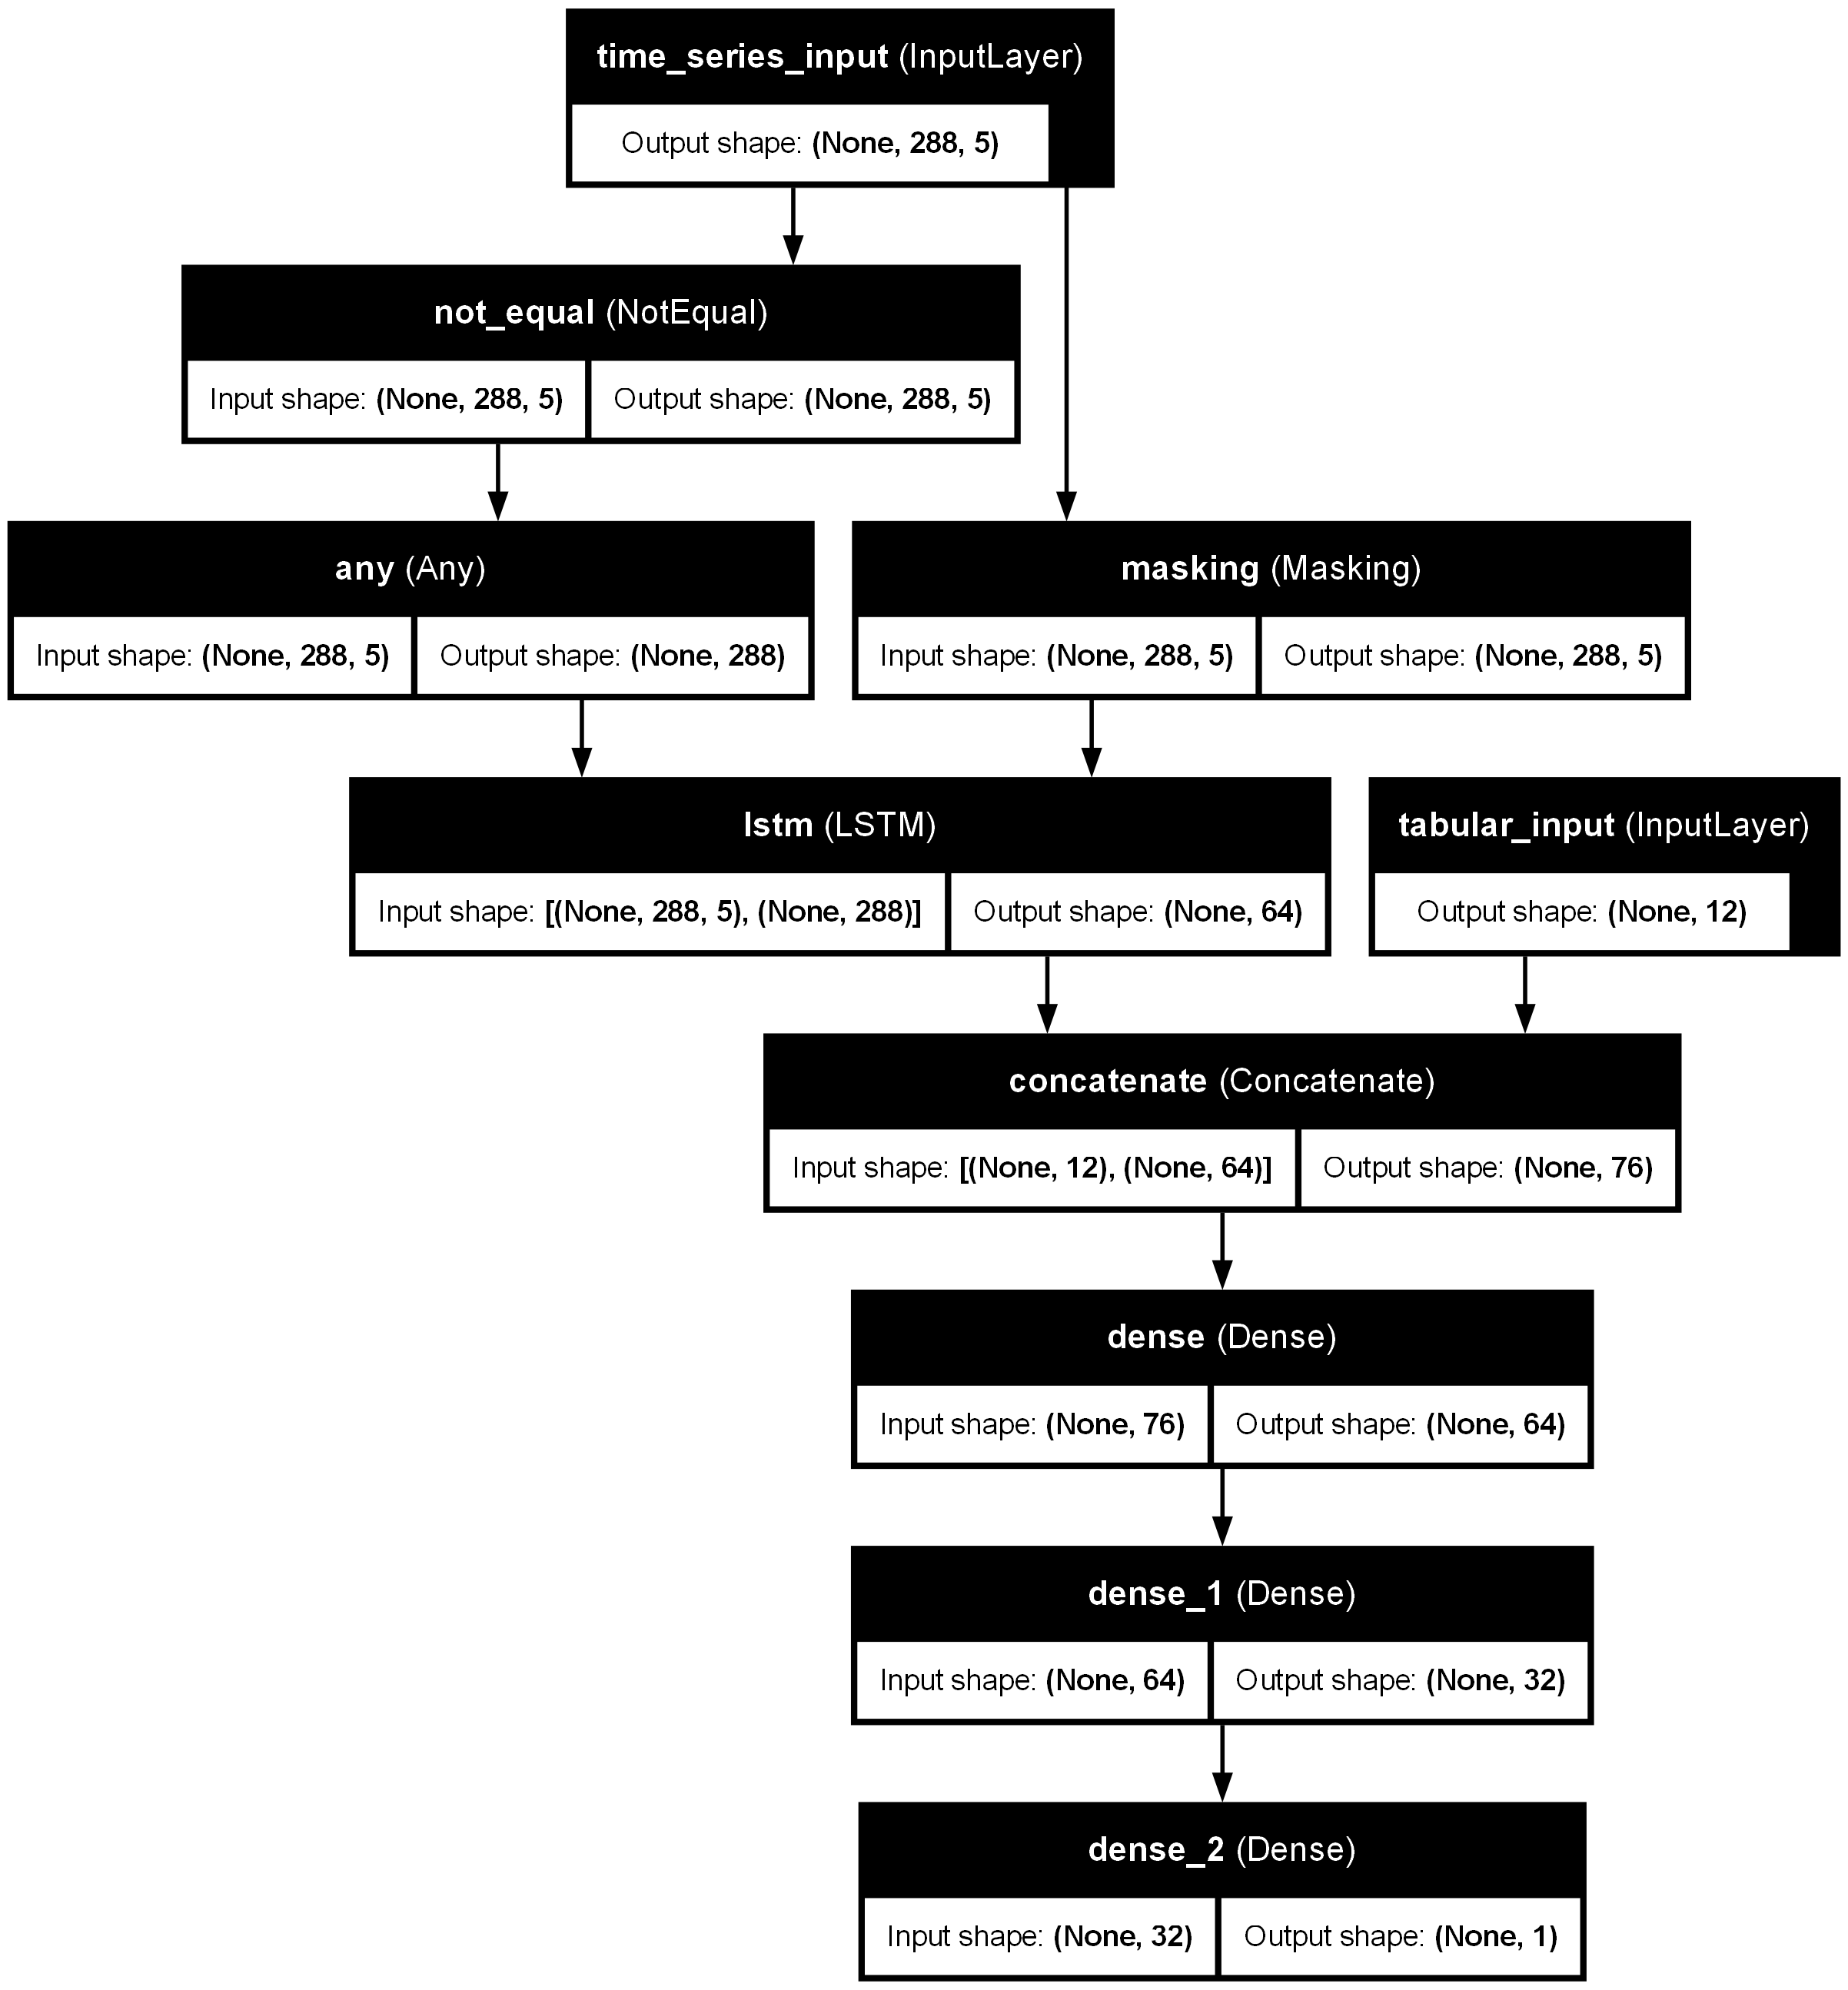

In [11]:
# Generate a plot of the model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [12]:
# Split the data into training and validation sets
X_tabular_train, X_tabular_val, X_time_series_train, X_time_series_val, y_train, y_val = train_test_split(
    X_tabular, X_time_series, y, test_size=0.15, random_state=42
)

In [13]:
# Ensure tabular and time-series data are float32
X_tabular_train = X_tabular_train.astype('float32')
X_tabular_val = X_tabular_val.astype('float32')
X_time_series_train = X_time_series_train.astype('float32')
X_time_series_val = X_time_series_val.astype('float32')

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    [X_tabular_train, X_time_series_train], y_train,
    validation_data=([X_tabular_val, X_time_series_val], y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50


c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['tabular_input', 'time_series_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.5911 - loss: 0.6730 - roc_auc: 0.5810 - val_accuracy: 0.6848 - val_loss: 0.5895 - val_roc_auc: 0.7704
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.6437 - loss: 0.6011 - roc_auc: 0.7608 - val_accuracy: 0.7283 - val_loss: 0.5428 - val_roc_auc: 0.8250
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7104 - loss: 0.5693 - roc_auc: 0.7720 - val_accuracy: 0.7283 - val_loss: 0.5309 - val_roc_auc: 0.8148
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7210 - loss: 0.5492 - roc_auc: 0.7905 - val_accuracy: 0.7609 - val_loss: 0.5197 - val_roc_auc: 0.8129
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.7545 - loss: 0.5326 - roc_auc: 0.8054 - val_accuracy: 0.7609 - val_loss: 0.5102 - val_roc_auc: 0.8099
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7555 - loss: 0.4940 - roc_auc: 0.8385 - val_accuracy: 0.7609 - val_loss: 0.5206 - val_roc_auc: 0.7981
Epoch 7/

In [16]:
# Evaluate on the validation set with additional metrics
loss, accuracy, roc_auc = model.evaluate([X_tabular_val, X_time_series_val], y_val)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
print(f"Validation ROC AUC: {roc_auc}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8038 - loss: 0.4157 - roc_auc: 0.8739
Validation Loss: 0.4846656620502472
Validation Accuracy: 0.77173912525177
Validation ROC AUC: 0.8215054273605347


In [19]:
# Generate predictions on the validation set
y_pred_prob = model.predict([X_tabular_val, X_time_series_val]).flatten()

# Convert probabilities to binary labels (using 0.5 threshold for binary classification)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print the classification report
print(classification_report(y_val, y_pred, target_names=["Class 0", "Class 1"]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
              precision    recall  f1-score   support

     Class 0       0.81      0.87      0.84        62
     Class 1       0.68      0.57      0.62        30

    accuracy                           0.77        92
   macro avg       0.74      0.72      0.73        92
weighted avg       0.76      0.77      0.77        92



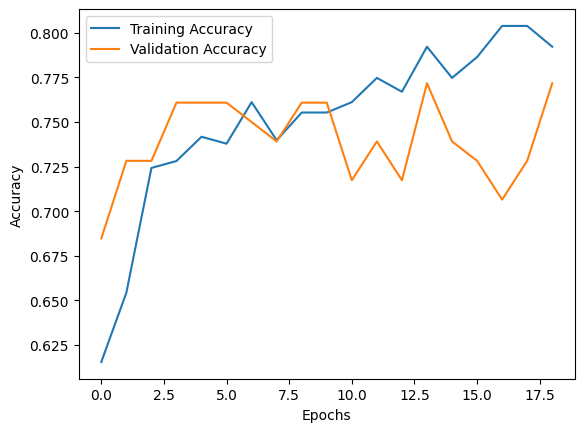

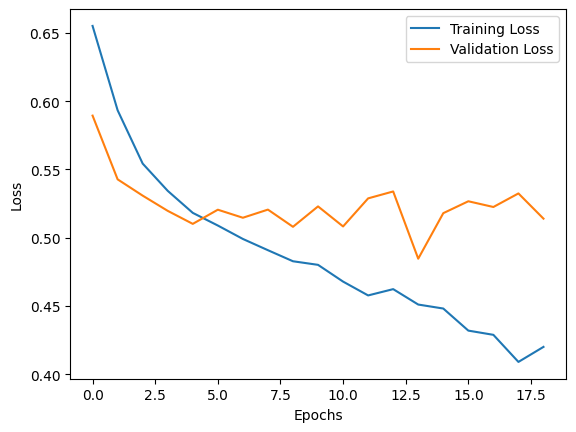

In [20]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Predictions on the validation set
predictions = model.predict([X_tabular_val, X_time_series_val])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


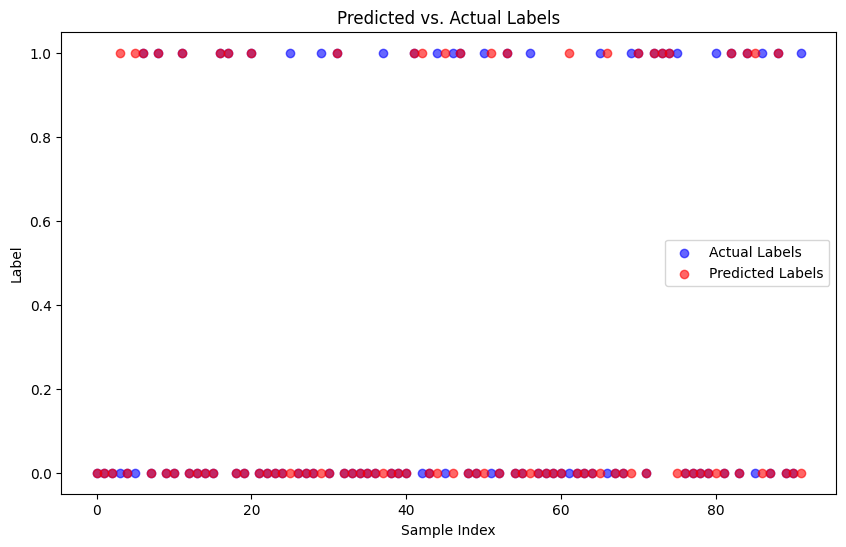

In [22]:
# Generate predictions on the validation set
predictions = model.predict([X_tabular_val, X_time_series_val])

# If your predictions are probabilities, convert them to binary labels
predicted_labels = (predictions > 0.5).astype(int).flatten()  # Threshold at 0.5 for binary classification

# Flatten y_val if it’s not already
actual_labels = y_val.flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_labels)), actual_labels, color="blue", label="Actual Labels", alpha=0.6)
plt.scatter(range(len(predicted_labels)), predicted_labels, color="red", label="Predicted Labels", alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Label")
plt.legend()
plt.title("Predicted vs. Actual Labels")
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


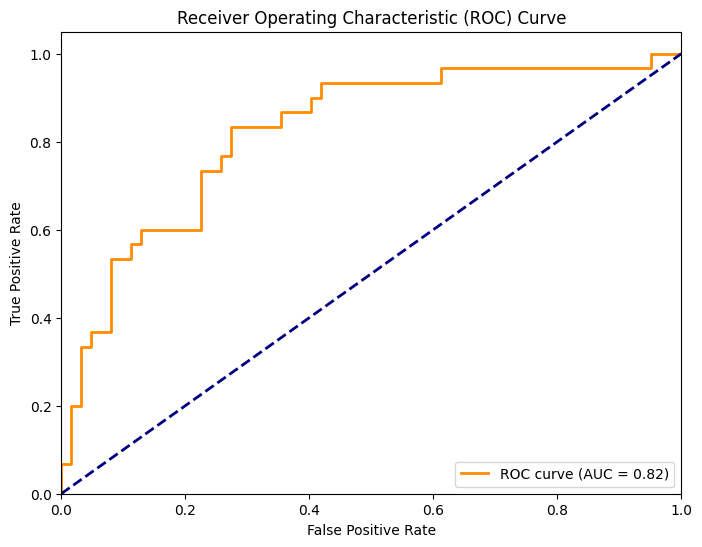

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the validation set
y_pred_prob = model.predict([X_tabular_val, X_time_series_val]).flatten()

# Compute the FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Calculate the ROC AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()
